In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import OUT_MODEL_DIR
from utils.load import load_data, save_file

In [4]:
# directory overview

In [5]:
def get_model_list(path):
    dir_list = os.listdir(OUT_MODEL_DIR)
    dir_ist = [item for item in dir_list if '.' not in item or item == "archive"]
    dir_list = [item for item in dir_list if item != "archive"]
    return dir_list

In [6]:
get_model_list(OUT_MODEL_DIR)

['lgb_8055_years2021_2011_sp_close_lead1_sentFalse',
 'lgb_8055_years2021_2015_sp_close_lead1_sentFalse',
 'lgb_8055_years2021_2017_sp_close_lead1_sentFalse',
 'lgb_8055_years2021_2018_sp_close_lead1_sentFalse',
 'lgb_8055_years2021_2019_sp_close_lead1_sentFalse',
 'ols_8055_years2021_2011_sp_close_lead1_sentFalse',
 'ols_8055_years2021_2015_sp_close_lead1_sentFalse',
 'ols_8055_years2021_2017_sp_close_lead1_sentFalse',
 'ols_8055_years2021_2018_sp_close_lead1_sentFalse',
 'ols_8055_years2021_2019_sp_close_lead1_sentFalse']

In [7]:
def get_model_dict(path,
                   dict_file_end: str = '_data_dict.pkl'):
    dir_list = os.listdir(path)
    dict_name = [item for item in dir_list if dict_file_end in item]
    
    if len(dict_name) > 1:
        dict_name = dict_name[-1]
    else:
        dict_name = dict_name[0]
    
    file = load_data(file_name=dict_name, file_path=path)
    return file    

In [8]:
_ = get_model_dict(os.path.join(OUT_MODEL_DIR, "ols_8055_years2021_2011_sp_close_lead1_sentFalse"));

In [9]:
class ModelMetrics:
    
    def __init__(self,
                 dict_):
        self._metrics = dict_["model_metrics"]
        
        self.model_type = self._metrics["model_type"]
        self.predicted = dict_["model_features"]["predicted"]
        self.data_len = self._metrics["data_len"]
        self.is_sent = self._metrics["is_sent"]
        self.week_day = self._metrics["week_day"]
        self.year_spread = self._metrics["year_spread"]
        self.rmse = self._metrics["rmse"]
        self.mse = self._metrics["mse"]
        self.mae = self._metrics["mae"]
        self.r2 = self._metrics["r2"]
        pass

In [10]:
def get_metrics_overview(model_list: list):
    
    model_type = []
    predicted = []
    data_len = []
    is_sent = []
    week_day = []
    year_spread = []
    rmse = []
    mse = []
    mae = []
    r2 = []
    col_name = []
    for i, item in enumerate(model_list):
        model_type.append(item.model_type)
        predicted.append(item.predicted)
        data_len.append(item.data_len)
        is_sent.append(item.is_sent)
        week_day.append(item.week_day)
        year_spread.append(item.year_spread)
        rmse.append(item.rmse)
        mse.append(item.mse)
        mae.append(item.mae)
        r2.append(item.r2)
        col_name.append(f'model_{i}')
    
    df = pd.DataFrame([model_type,
                       predicted,
                       data_len,
                       is_sent,
                       week_day,
                       year_spread,
                       rmse,
                       mse,
                       mae,
                       r2],
                     index=["model_type", "predicted", "data_len", "is_sent", 'week_day', 'year_spread', 'rmse', "mse", "mae", "r2"])
    
    return df.transpose()
        
        

In [11]:
model_list = []
for item in get_model_list(OUT_MODEL_DIR):
    model_list.append(ModelMetrics(get_model_dict(os.path.join(OUT_MODEL_DIR, item))))
df = get_metrics_overview(model_list)

In [12]:
df

,model_type,predicted,data_len,is_sent,week_day,year_spread,rmse,mse,mae,r2
0,lgb,sp_close_lead1,8055,False,daily,years2021_2011,0.016647,0.000277,0.010146,-0.108105
1,lgb,sp_close_lead1,8055,False,daily,years2021_2015,0.011044,0.000122,0.00838,-0.459737
2,lgb,sp_close_lead1,8055,False,daily,years2021_2017,0.00976,0.000095,0.007249,-0.305464
3,lgb,sp_close_lead1,8055,False,daily,years2021_2018,0.009331,0.000087,0.007307,-0.482434
4,lgb,sp_close_lead1,8055,False,daily,years2021_2019,0.009283,0.000086,0.007087,-0.503174
5,ols,sp_close_lead1,8055,False,daily,years2021_2011,0.017885,0.00032,0.010533,-0.58179
6,ols,sp_close_lead1,8055,False,daily,years2021_2015,0.015755,0.000248,0.010017,0.051838
7,ols,sp_close_lead1,8055,False,daily,years2021_2017,0.010902,0.000119,0.008233,-0.130927
8,ols,sp_close_lead1,8055,False,daily,years2021_2018,0.017911,0.000321,0.013585,-3.312626
9,ols,sp_close_lead1,8055,False,daily,years2021_2019,0.016998,0.000289,0.012875,-3.48725


In [13]:
df_p = df.pivot_table(index=["model_type"],
               columns=["year_spread"],
               values=["rmse"])

In [14]:
df_p = df_p * -1

In [15]:
df_p.columns = [item[1] for item in df_p.columns]

In [16]:
df_p

,years2021_2011,years2021_2015,years2021_2017,years2021_2018,years2021_2019
model_type,,,,,
lgb,-0.016647,-0.011044,-0.009760,-0.009331,-0.009283
ols,-0.017885,-0.015755,-0.010902,-0.017911,-0.016998


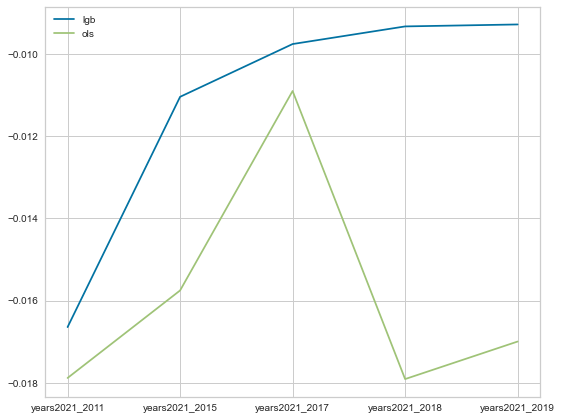

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(df_p.loc['lgb'])

ax.plot(df_p.loc['ols'])

# ax[2].plot(df_p.loc[True, 'lgb'] - df_p.loc[False, 'lgb'])
# ax[2].plot(df_p.loc[True, 'ols'] - df_p.loc[False, 'ols'])

ax.legend(["lgb", "ols"])
# ax[1].legend(["lgb", "ols"])
# ax[2].legend(["lgb", "ols"])

# ax[0].set_title("Excl. Sentiment data")
# ax[1].set_title("Incl. Sentiment data")
# ax[2].set_title("Performance gain by sentiment data")

# # ax[0].set_ylim([-0.0008, 0])
# # ax[1].set_ylim([-0.0008, 0])

plt.tight_layout()
plt.show()